In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl


In [2]:
df = pd.read_parquet('../data/cryptos/BTCUSD_2020-04-07_2022-04-06.parquet', engine = 'pyarrow')
df

,VOLUME,VW,OPEN,CLOSE,HIGHT,LOW,t,TRANSACTIONS,DATE
0,15.835240,7358.0688,7363.09,7352.66,7364.21,7343.13,1586281680000,101,2020-04-07 17:48:00
1,7.652123,7360.3784,7358.42,7361.54,7367.90,7349.32,1586281740000,69,2020-04-07 17:49:00
2,16.446123,7356.0049,7361.54,7354.09,7361.54,7340.09,1586281800000,93,2020-04-07 17:50:00
3,7.068813,7351.8802,7354.14,7345.00,7357.53,7340.00,1586281860000,71,2020-04-07 17:51:00
4,8.162850,7351.9813,7350.10,7355.16,7357.00,7343.35,1586281920000,71,2020-04-07 17:52:00
...,...,...,...,...,...,...,...,...,...
1048685,37.006803,43136.9003,43146.71,43144.08,43187.00,43123.70,1649289240000,683,2022-04-06 23:54:00
1048686,65.685080,43175.9371,43144.08,43188.59,43261.00,43138.37,1649289300000,1232,2022-04-06 23:55:00
1048687,25.763792,43166.3569,43188.44,43111.80,43233.00,43111.80,1649289360000,797,2022-04-06 23:56:00
1048688,21.241159,43139.1620,43122.93,43149.90,43170.00,43115.26,1649289420000,647,2022-04-06 23:57:00


In [3]:
def _get_weight_ffd(d, thres, lim):
    w, k = [1.], 1
    ctr = 0
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        ctr += 1
        if ctr == lim - 1:
            break
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

In [4]:

def frac_diff_ffd(x, d, thres=1e-5, disable_warning=False):
    if np.max(x) > 10.0 and not disable_warning:
        print('WARNING: have you applied log before calling this function? If yes, discard this warning.')
    w = _get_weight_ffd(d, thres, len(x))
    width = len(w) - 1
    output = []
    output.extend([0] * width)
    for i in range(width, len(x)):
        output.append(np.dot(w.T, x[i - width:i + 1])[0])
    return np.array(output) 

In [5]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    # Get default color style from pandas - can be changed to any other color list
    if cols is None:
        cols = data.columns
    if len(cols) == 0:
        return
    colors = ['r', 'b', 'g']

    # First axis
    ax = data[cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data[cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label
  
    ax.legend(lines, labels, loc=0)
    return ax

            CLOSE  Fractional differentiation FFD
1048685  43144.08                        0.385624
1048686  43188.59                        0.386871
1048687  43111.80                        0.384824
1048688  43149.90                        0.386407
1048689  43173.96                        0.386850


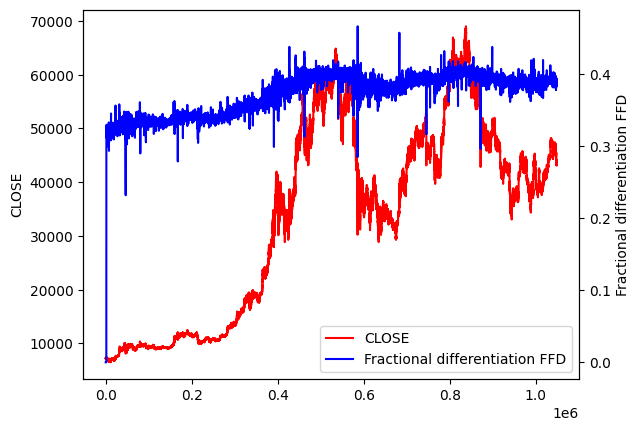

In [6]:
fractional_returns = frac_diff_ffd(df['CLOSE'].apply(np.log).values, d=0.4)
df['Fractional differentiation FFD'] = fractional_returns
df = df[['CLOSE', 'Fractional differentiation FFD']]
print(df.tail())
plot_multi(df)
plt.show()